# Классификация на датасете Fashion MNIST

Все задания выполнены в этом одном файле. Сначала идет код заготовок для обучения модели и построения графиков, потом уже сами задания

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision.transforms import transforms
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from tqdm import tqdm
from matplotlib import pyplot as plt

## Посмотрим на датасет

In [55]:
def show_10_random_images(data):
    ixs = [np.random.randint(0, len(data)) for _ in range(10)]
    plt.figure(figsize=(10,5))

    for i in range(10):
        x, y = data[ixs[i]]
        plt.subplot(2, 5, i + 1)
        plt.title(f'y_true: {y}')
        plt.imshow(x[0], cmap="gray")

    plt.show()

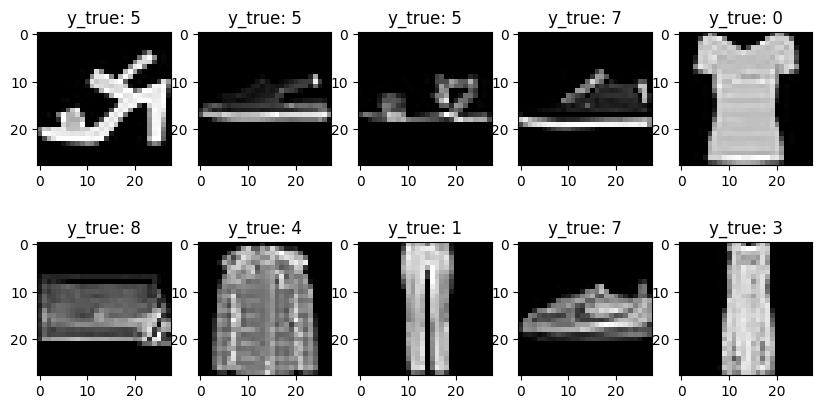

In [56]:
show_10_random_images(datasets.FashionMNIST(root="fmnist_source", train=True, transform=transforms.ToTensor()))

## Код для теста моделей

### Функции цикла обучения

In [2]:
def get_accuracy(output, labels):
    pred = output.max(1)[1]
    return accuracy_score(labels, pred)

In [3]:
def train_epoch(model, data, optimiser, loss_func, epoch_num, batch_size):
    # вспомогательные штуки
    tq_iter = tqdm(range(len(data)))
    tq_iter.set_description(f"Epoch {epoch_num + 1} train")
    batch_losses = np.empty((1, 2))
    accuracies = np.empty((1, 2))
    all_output = torch.empty((1, 10))
    all_labels = torch.empty((1))
    iter_data = iter(data)
    total_loss = 0
    # установка training мода
    model.train()
    for ix in tq_iter:
        images, labels = next(iter_data)
        if len(labels) != batch_size:
            continue
        # считаем ошибку и обновляем веса
        optimiser.zero_grad()
        output = model(images)
        loss = loss_func(output, labels)
        loss.backward()
        optimiser.step()
        # информация для вывода
        total_loss += loss.item()
        batch_losses = np.append(batch_losses, [[ix + len(data) * epoch_num, loss.item()]], axis=0)
        accuracies = np.append(accuracies, [[ix + len(data) * epoch_num, get_accuracy(output, labels)]], axis=0)
        all_output = torch.cat((all_output, output))
        all_labels = torch.cat((all_labels, labels))
        tq_iter.set_postfix({"loss": round(loss.item(), 3), "acc": get_accuracy(output, labels)})
    return batch_losses[1:], accuracies[1:], total_loss / len(data), get_accuracy(all_output[1:], all_labels[1:])

In [4]:
def validate_epoch(model, data, loss_func, epoch_num, batch_size):
    # вспомогательные штуки
    tq_iter = tqdm(range(len(data)))
    tq_iter.set_description(f"Epoch {epoch_num + 1} valid")
    iter_data = iter(data)
    batch_losses = np.empty((1, 2))
    accuracies = np.empty((1, 2))
    all_output = torch.empty((1, 10))
    all_labels = torch.empty((1))
    total_loss = 0
    # установка evaluating мода
    model.eval()
    with torch.no_grad():
        for ix in tq_iter:
            images, labels = next(iter_data)
            if len(labels) != batch_size:
                continue
            output = model(images)
            loss = loss_func(output, labels).item()
            # информация для вывода
            total_loss += loss
            batch_losses = np.append(batch_losses, [[ix + len(data) * epoch_num, loss]], axis=0)
            accuracies = np.append(accuracies, [[ix + len(data) * epoch_num, get_accuracy(output, labels)]], axis=0)
            all_output = torch.cat((all_output, output))
            all_labels = torch.cat((all_labels, labels))
            tq_iter.set_postfix({"loss": round(loss, 3), "acc": get_accuracy(output, labels)})
    return batch_losses[1:], accuracies[1:], total_loss / len(data), get_accuracy(all_output[1:], all_labels[1:])


### Функция для построения графиков

In [5]:
def plot_data_per_epoch(fig, x, y, title="Model", log_iters=10, **kwargs):
    fig.set_title(title)
    fig.plot(x[::log_iters], y[::log_iters], **kwargs)
    fig.axvline(x[-1], c="black", linestyle="--")
    fig.hlines(y=np.mean(y), xmin=x[0], xmax=x[-1], colors="red")

def plot_data(fig, xs, ys, labels, title="Model", **kwargs):
    fig.set_title(title)
    fig.set_xticks(xs[0])
    for x, y, label in zip(xs, ys, labels):
        fig.plot(x, y, label=label, **kwargs)
    fig.legend()


### Тест архитектуры

In [6]:
def test_architecture(dataset_train, dataset_test, model, optimiser, loss_func, 
                      num_epochs=3, batch_size=64, logging_iters_train=10, logging_iters_valid=3,
                      model_title="Model"):
    
    # загрузхка датасетов
    data_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    data_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
    optimiser = optimiser(model.parameters(), lr=1e-3)
    TRAIN_LOSSES, VALID_LOSSES = [], []
    TRAIN_ACCS, VALID_ACCS = [], []

    _, axs = plt.subplots(3, 2, figsize=(15, 10))
    for i in range(num_epochs):
        # train 
        train_loss, train_accs, train_epoch_loss, train_epoch_acc = train_epoch(
            model, data_train, optimiser, loss_func, i, batch_size
        )
        # test
        valid_loss, valid_accs, valid_epoch_loss, valid_epoch_acc = validate_epoch(
            model, data_test, loss_func, i, batch_size
        )
        TRAIN_LOSSES.append(train_epoch_loss)
        TRAIN_ACCS.append(train_epoch_acc)
        VALID_LOSSES.append(valid_epoch_loss)
        VALID_ACCS.append(valid_epoch_acc)

        # графики обучения
        plot_data_per_epoch(axs[0, 0], train_loss[:, 0], train_loss[:, 1], 
                            title=f"{model_title} train losses", log_iters=logging_iters_train)
        plot_data_per_epoch(axs[0, 1], train_accs[:, 0], train_accs[:, 1],
                            title=f"{model_title} train accuracy", log_iters=logging_iters_train)
        plot_data_per_epoch(axs[1, 0], valid_loss[:, 0], valid_loss[:, 1],
                            title=f"{model_title} valid losses", log_iters=logging_iters_valid)
        plot_data_per_epoch(axs[1, 1], valid_accs[:, 0], valid_accs[:, 1],
                            title=f"{model_title} valid accuracy", log_iters=logging_iters_valid)
        clear_output()
    plot_data(axs[2, 0], [range(num_epochs), range(num_epochs)], [TRAIN_LOSSES, VALID_LOSSES], 
              ["Train loss", "Valid loss"], title="Model epoch loss")
    plot_data(axs[2, 1], [range(num_epochs), range(num_epochs)], [TRAIN_ACCS, VALID_ACCS], 
              ["Train accuracy", "Valid accuracy"], title="Model epoch accuracy")
    plt.show()
    return max(VALID_ACCS)
    

## Задание 1. Полносвязная модель

In [60]:
fmnist_train = datasets.FashionMNIST(root="fmnist_source", train=True, transform=transforms.ToTensor())
fmnist_test = datasets.FashionMNIST(root="fmnist_source", train=False, transform=transforms.ToTensor())

### Код модели

In [97]:
class FullyConnectedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 10),
        )
    
    def forward(self, x):
        return self.seq(x.reshape(-1, 28 * 28))

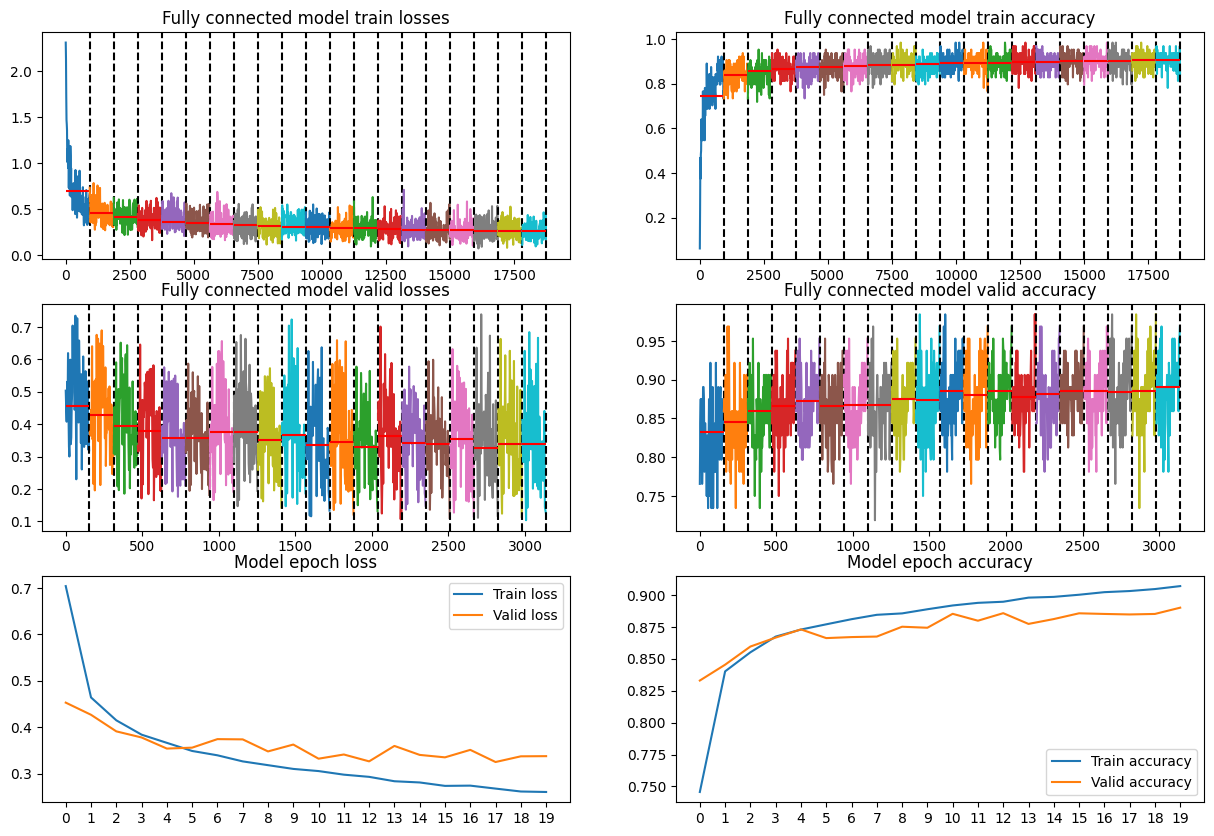

Max epoch accuracy on test: 0.8901241987179487


In [99]:
model1_acc = test_architecture(fmnist_train, fmnist_test, FullyConnectedModel(), 
                               optim.Adam, nn.CrossEntropyLoss(), 
                               model_title="Fully connected model", num_epochs=20)
print(f"Max epoch accuracy on test: {model1_acc}")

**Вывод**: как можно заметить, модель не сошлась. После четвертой эпохи loss на тестовой выборке стал колебаться - модель, вероятно, несколько переобучается, несмотря на использование dropout. Наибольшая точность составила 89%, то есть модель угадывает примерно 9 предметов из 10, что неплохо, но можно лучше.

## Задание 2. CNN-модель

In [62]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        self.seq3 = nn.Sequential(
            nn.Linear(64 * 5 * 5, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
            
        )
    
    def forward(self, x):
        x = self.seq2(self.seq1(x))
        x = x.view(x.size(0), -1)
        x = self.seq3(x)
        return x

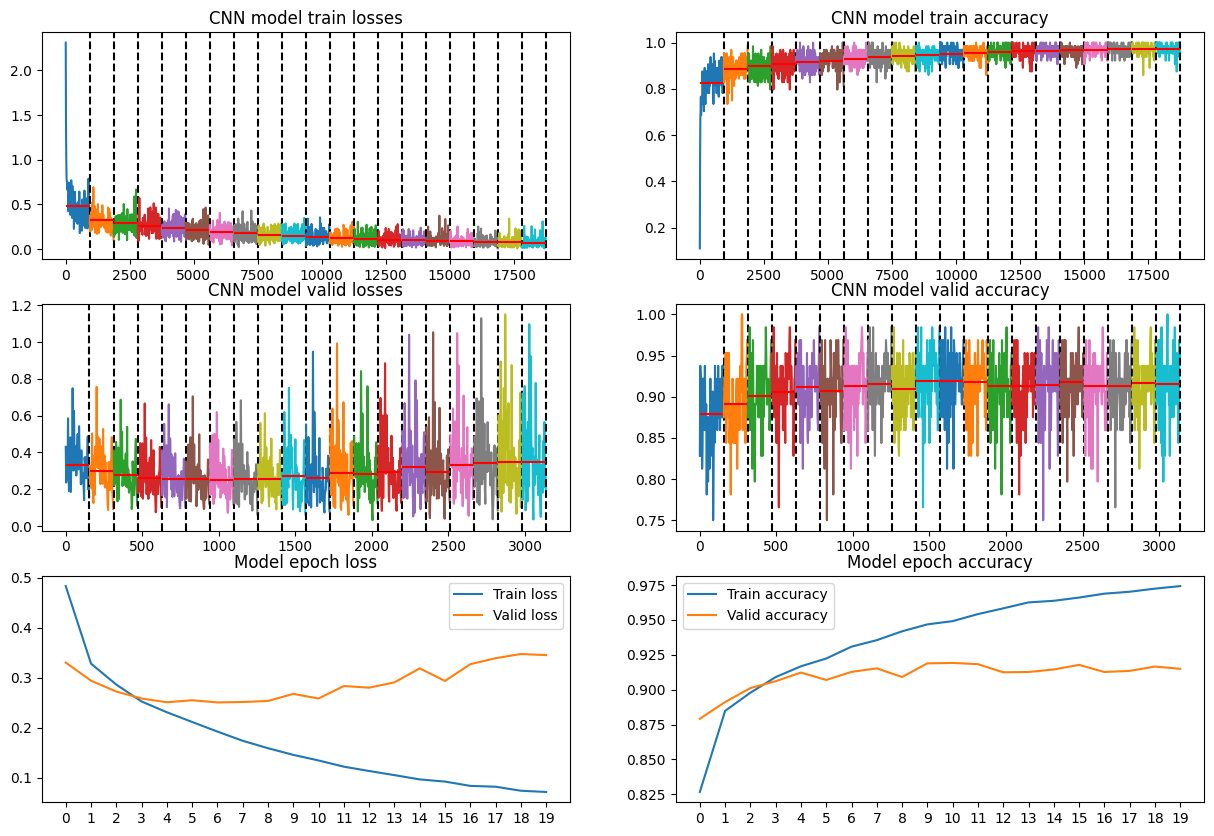

Max epoch accuracy on test: 0.9191706730769231


In [113]:
model2_acc = test_architecture(fmnist_train, fmnist_test, CNN(), 
                               optim.Adam, nn.CrossEntropyLoss(), 
                               model_title="CNN model", num_epochs=20)
print(f"Max epoch accuracy on test: {model2_acc}")

**ВЫВОД**: модель с применением свертки дала результат чуть лучше (92%), однако она тоже не сошлась, переобучение (думаю, что это оно) пошло с 4 эпохи (хотя были использованы средства для ее уменьшения). Зато, в отличие от линейной модели, эта модель горздо быстрее уменьшила loss на данных для тренинга, значит, потенциально точность может быть еще увеличена, если справиться с увеличением потерь на тестовой выборке

## Задание 3. Аугментация

Найдем для датасета среднее значение и среднеквадратичное отклонение, чтобы использовать для нормализации

In [50]:
def calc_mean_and_std(dataset):
    data = iter(torch.utils.data.DataLoader(dataset))
    all_data = torch.empty((1, 28 * 28))
    for i in tqdm(range(len(data))):
        x = next(data)[0]
        all_data = torch.cat((all_data, x.view(x.size(1), -1)))
    return torch.std_mean(all_data)

In [51]:
calc_mean_and_std(datasets.FashionMNIST(root="fmnist_source", train=True, transform=transforms.ToTensor()))

100%|██████████| 60000/60000 [09:11<00:00, 108.73it/s]


(tensor(0.3530), tensor(0.2860))

*В качестве методов аугментации применим*: отражение по горизонтали, поворот на угол, обрезка изображения

In [66]:
transform_list = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(35),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.3530,), (0.2860,)),
    # transforms.RandomErasing(scale=(0.02, 0.25), value="random")
])
fmnist_aug_train = datasets.FashionMNIST(root="fmnist_source", train=True, transform=transform_list)
fmnist_test = datasets.FashionMNIST(root="fmnist_source", train=True, transform=transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.3530,), (0.2860,))
]))

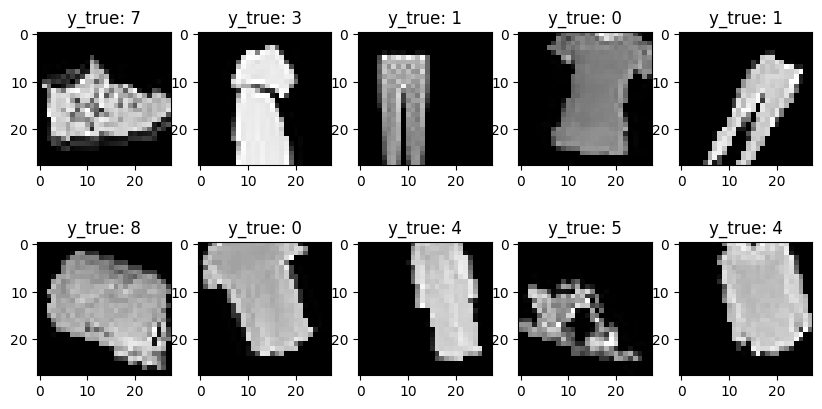

In [67]:
show_10_random_images(fmnist_aug_train)

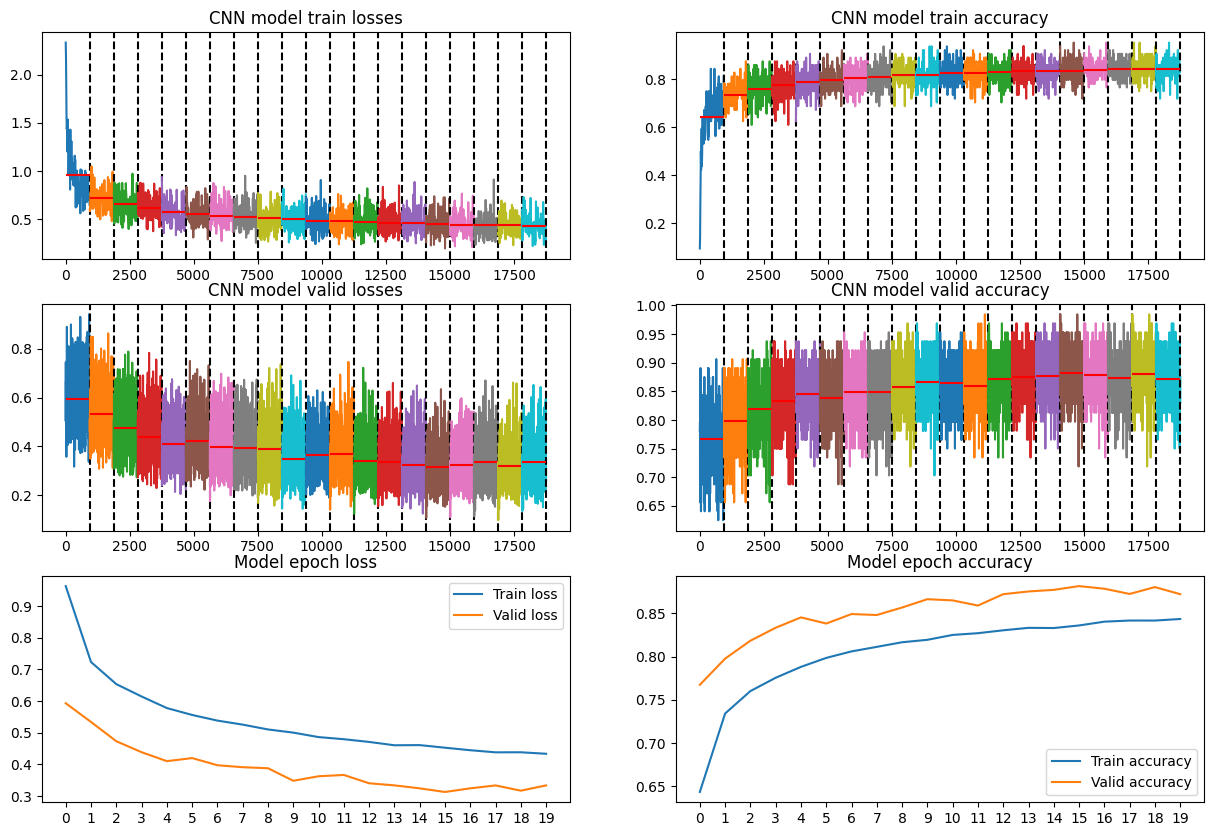

Max epoch accuracy on test: 0.8816535485592316


In [69]:
model3_acc = test_architecture(fmnist_aug_train, fmnist_test, CNN(), 
                               optim.Adam, nn.CrossEntropyLoss(), 
                               model_title="CNN model", num_epochs=20)
print(f"Max epoch accuracy on test: {model3_acc}")

**Вывод**: модель сошлась, аугментация помогла справиться с переобучением. Обучение просиходит медленне, чем с предыдыдущей моделью, что логично. За первые 20 эпох наибольшая точность составила 88%, и, вероятно, она может оказаться выше значений для предыдущих моделей, если пообучать ее в течение еще нескольких десятков эпох

## Задание 4. Skip-connection

Здесь реализована модель ResNet-18 (ее устройство взято из этой статьи: https://arxiv.org/pdf/1512.03385.pdf) (надеюсь, что можно придуманную модель реализовать самостоятельно, потому что придумывать полностью самому убийственно)

*Примечание*: код позволяет реализовать и ResNet-34, которая результаты лучше даст, но обучение будет намного дольше, поэтому я для теста взял эту модель. Так же по причине длительности обучения вместо рекомендованного размера изображений в 224х224 пикселя я беру 65х65

In [79]:
transform_list = transforms.Compose([
    transforms.Resize(65),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(35),
    transforms.RandomCrop(65, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.3530,), (0.2860,)),
    # transforms.RandomErasing(scale=(0.02, 0.25), value="random")
])
fmnist_aug_train = datasets.FashionMNIST(root="fmnist_source", train=True, transform=transform_list)
fmnist_test = datasets.FashionMNIST(root="fmnist_source", train=True, transform=transforms.Compose([
    transforms.Resize(65), transforms.ToTensor(), transforms.Normalize((0.3530,), (0.2860,))
]))

In [80]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
        )
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        resid = x
        out = self.seq(x)
        if self.downsample is not None:
            resid = self.downsample(x)
        out += resid
        out = self.relu(out)
        return out

In [81]:
class ResNet18(nn.Module):

    def __init__(self):
        self.in_channels = 64
        super().__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.relu = nn.ReLU()
        self.layer1 = self.create_layers(64, 2)
        self.layer2 = self.create_layers(128, 2, stride=2)
        self.layer3 = self.create_layers(256, 2, stride=2)
        self.layer4 = self.create_layers(512, 2, stride=2)
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.dropout = nn.Dropout2d(p=0.5)
        self.fc = nn.Linear(512, 10)

    def create_layers(self, out_channels, layers_count, stride=1):
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels,
                          kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )
        else:
            downsample = None

        layers = [Block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        layers.extend([Block(self.in_channels, out_channels) for _ in range(layers_count - 1)])
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.seq1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

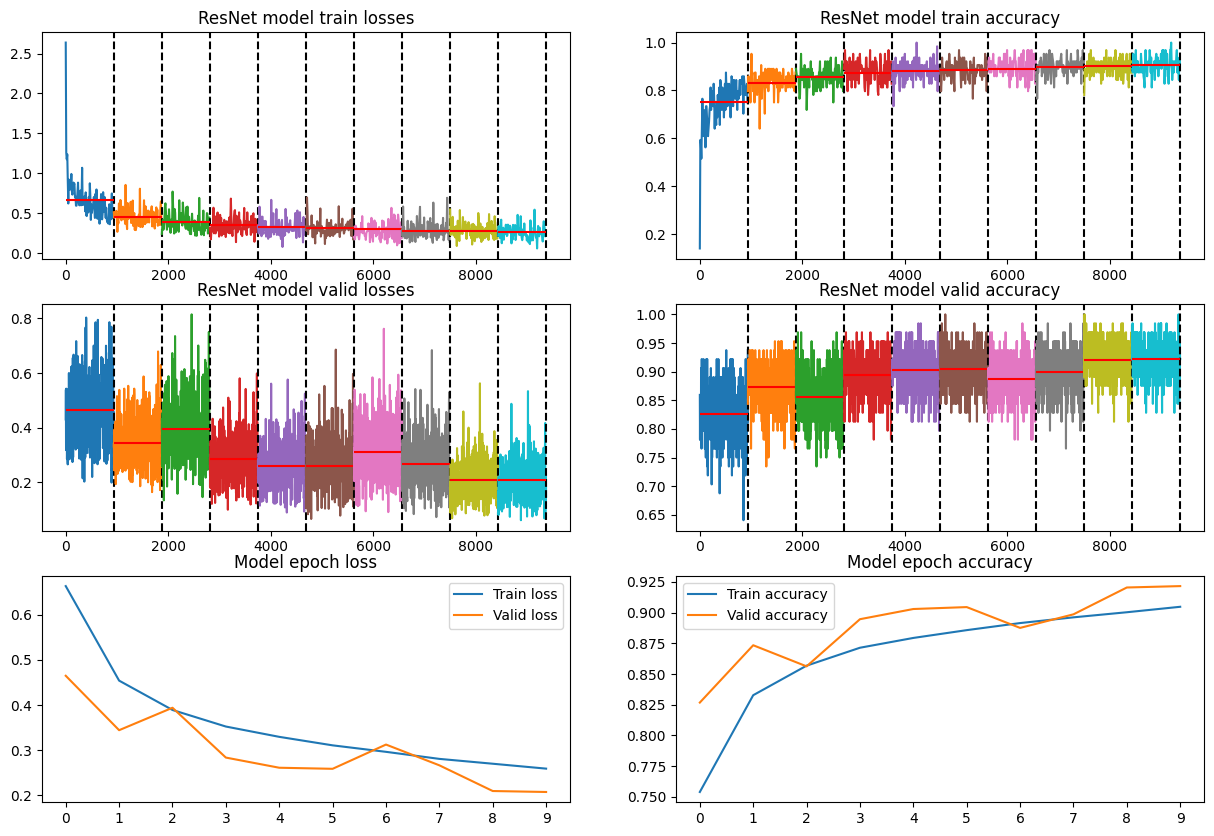

Max epoch accuracy on test: 0.9216081910352187


In [84]:
model4_acc = test_architecture(fmnist_aug_train, fmnist_test, ResNet18(), 
                               optim.Adam, nn.CrossEntropyLoss(), 
                               model_title="ResNet model", num_epochs=10)
print(f"Max epoch accuracy on test: {model4_acc}")

**Вывод**: модель начала сходится. По сравнению с обычной сверткой, эта модель быстрее уменьшила потери и увеличила точность (максимальное значение которой составляет 92.1%). При увеличении количества эпох показатели должны стать еще лучше. Поводов для переобучения вроде нет: используется и аугментация, и модель, нацеленная в том числе на борьбу с переобучением. Однако у нее есть огромный минус - скорость обучения. На моем устройстве это заняло 150 минут (на 10 эпох). По графикам можно заметить скачки в точности и потерях на валидационной выборке. Думаю, на это появлияло то, что я беру маленький размер изображений (чтобы модель обучилась за пару часов, а не дней). При наличии достаточной вычислителньой мощности эта модель, предполагаю, покажет результат лучше, чем простая свертка (на 10 эпохах этой модели резуультат лучше, чем на 20 эпохах сверточной, в последующих эпохах тенденция должна сохраниться)